# Import Libraries

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Statistical Analysis and Modeling
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.stats import gaussian_kde,zscore,chi2,f_oneway
from scipy.integrate import simps
from factor_analyzer import FactorAnalyzer,calculate_kmo,calculate_bartlett_sphericity
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from pickle import dump,load

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

# Data Loading

To begin, the CC GENERAL.csv file is imported as df, followed by converting all feature names to lowercase. The cust_id feature can be excluded from the analysis since it possesses a unique value for each row.

In [3]:
df = pd.read_csv("CC GENERAL.csv")
df.columns = df.columns.str.lower()
df = df.drop("cust_id",axis=1)
df.head(10)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


Check the shape of the dataset:

In [4]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 8950
Number of Columns	: 17


The dataset has 8,950 rows and 17 columns.

# Data Cleaning

Let's examine the dataset more closely. Specifically, we have identified two features, namely *minimum_payments* and *credit_limit*, that contain null or missing values.

In [5]:
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

,type,null,null_percentage,unique,sample
minimum_payments,float64,313,3.497207,8636,623.621303
credit_limit,float64,1,0.011173,205,3750.000000
balance,float64,0,0.000000,8871,929.113186
cash_advance_frequency,float64,0,0.000000,54,0.375000
prc_full_payment,float64,0,0.000000,47,0.272727
payments,float64,0,0.000000,8711,1906.032044
purchases_trx,int64,0,0.000000,173,204.000000
cash_advance_trx,int64,0,0.000000,65,10.000000
purchases_installments_frequency,float64,0,0.000000,47,0.625000
balance_frequency,float64,0,0.000000,43,0.666667


Since there are only a few null values in the dataset, it is possible to remove all rows that contain these null values.

In [6]:
df = df.dropna()
df = df.reset_index(drop=True)

# Data Exploration

Calculate the Pearson correlation between every feature.

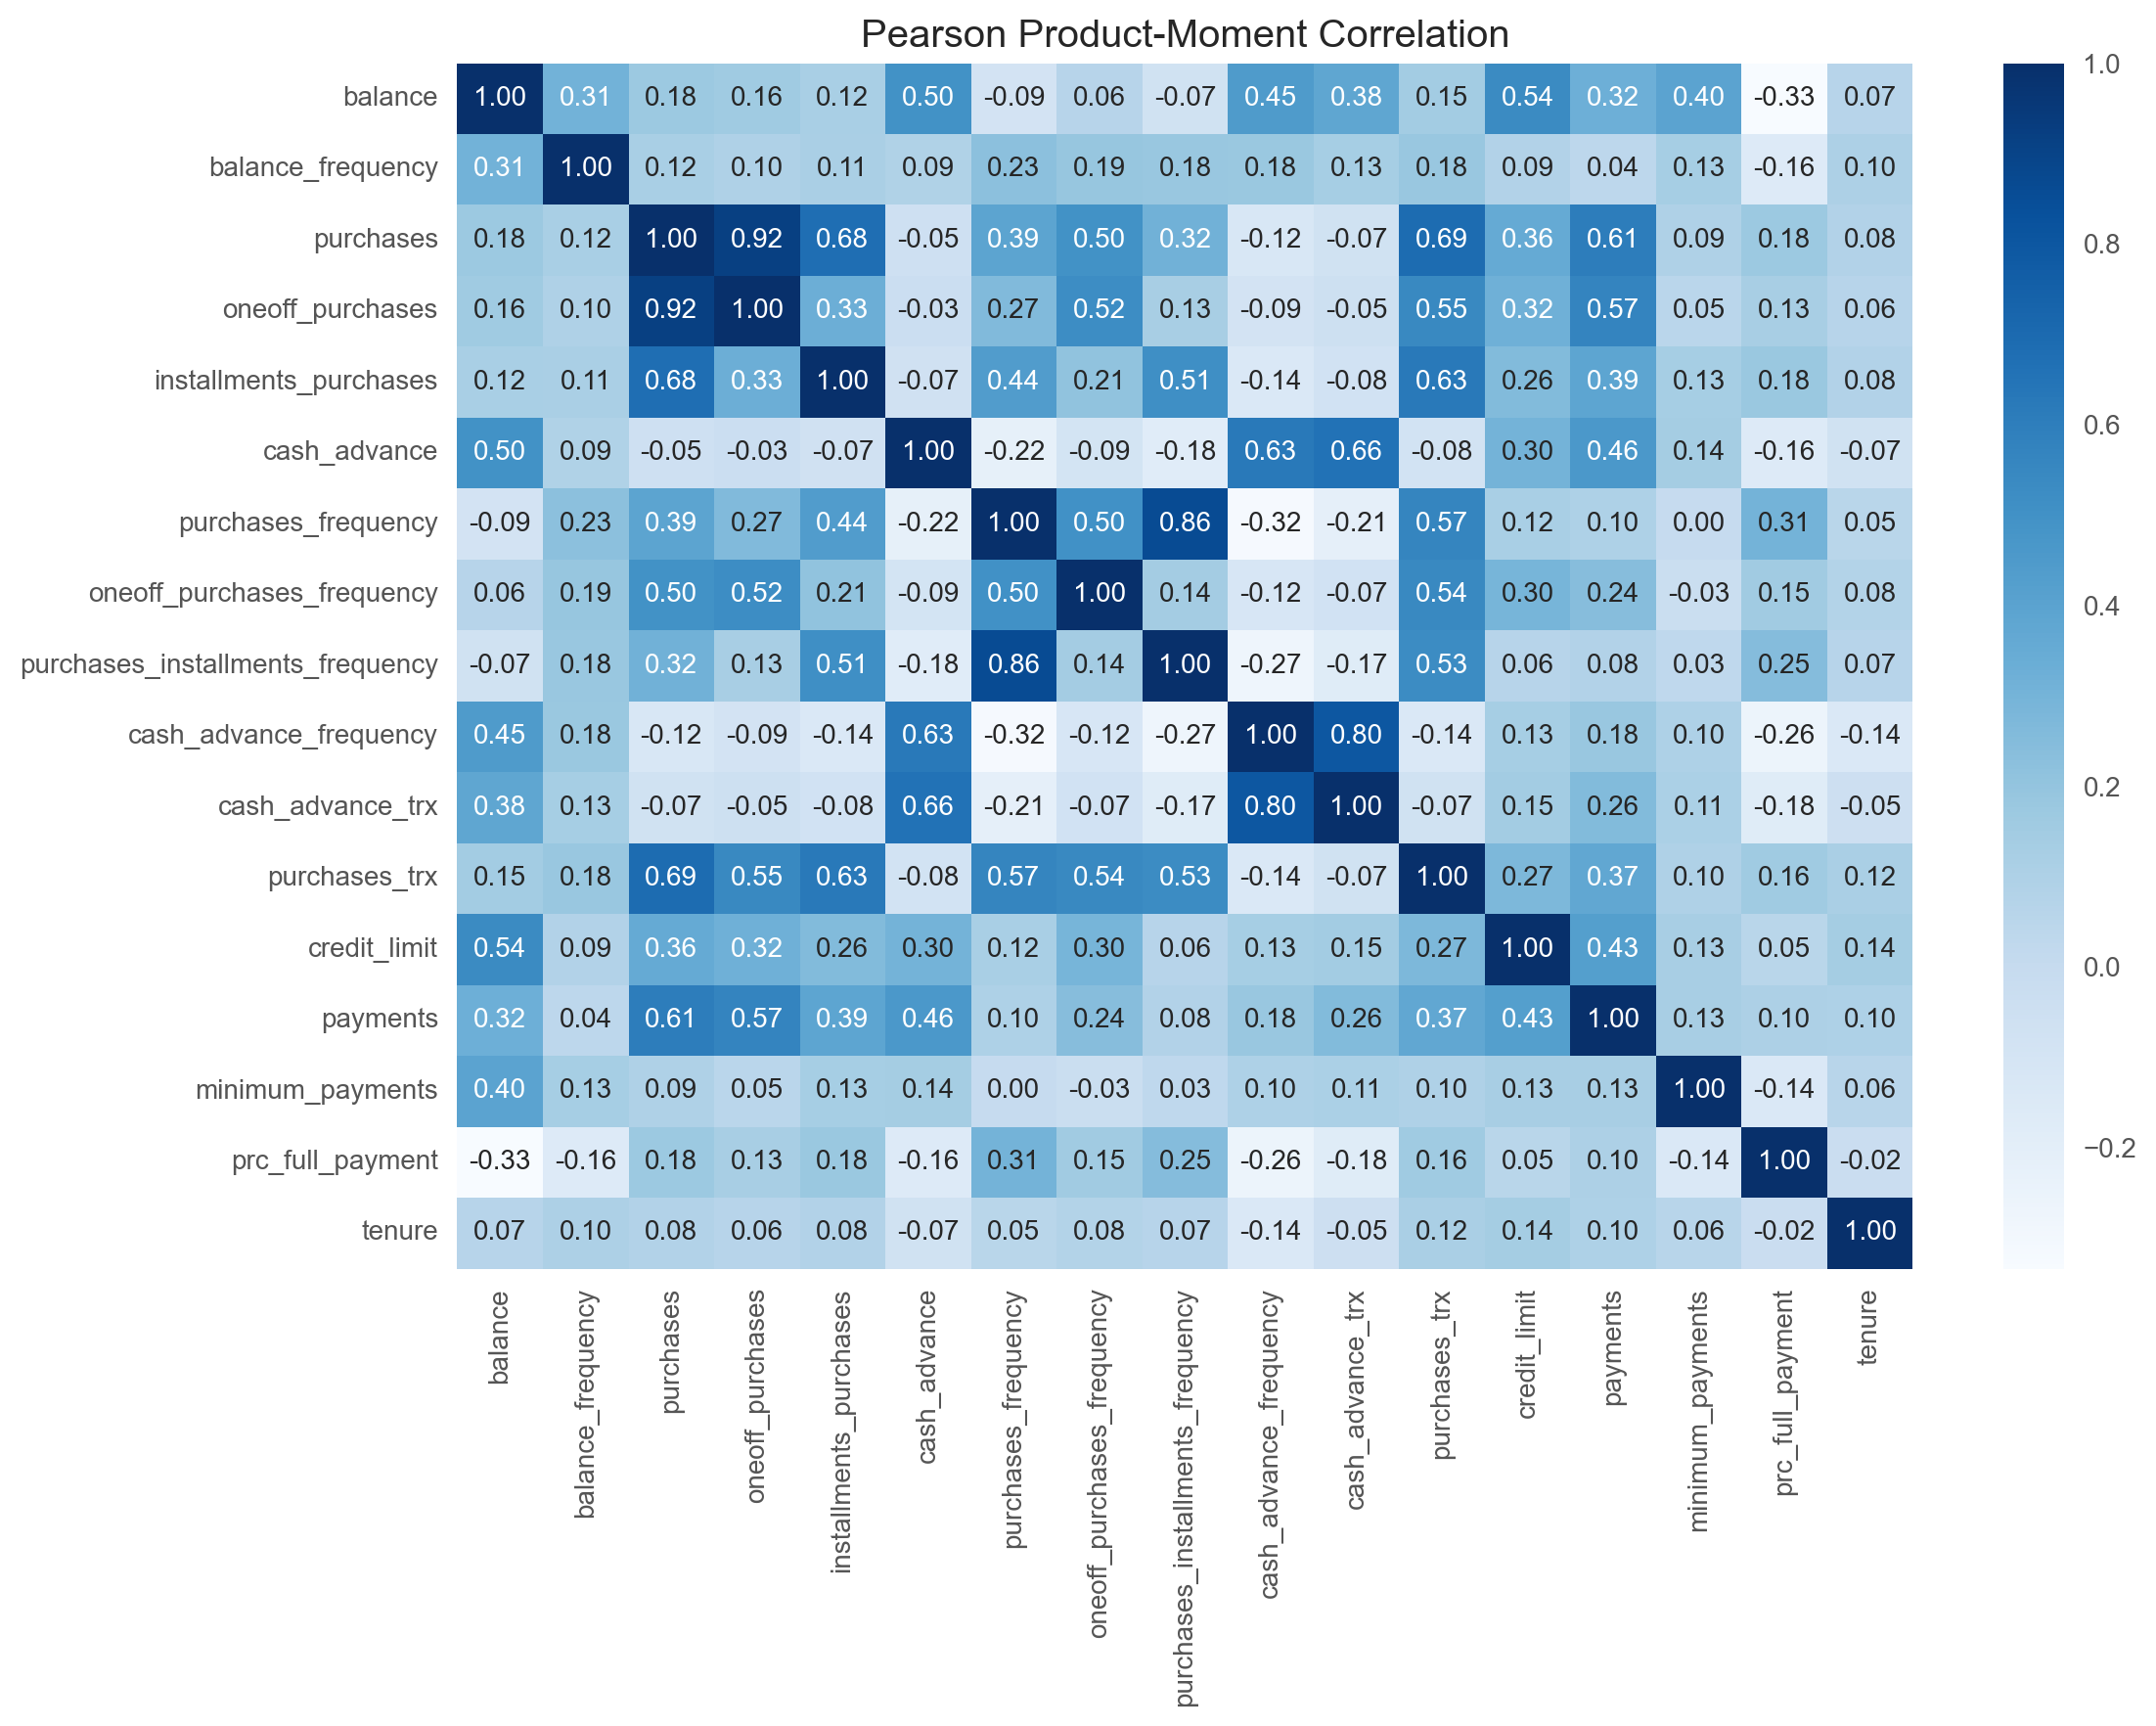

In [6]:
fig,ax = plt.subplots(figsize=(12,8),dpi=200)
sns.heatmap(ax=ax,data=df.corr(),cmap="Blues",annot=True,fmt=".2f")
ax.set_title("Pearson Product-Moment Correlation")
plt.show()

**Conlusion**: The combined balance of customers who make purchases most frequently, with a threshold set at 0.8, represents approximately 32.49% of the total balance across all customers.

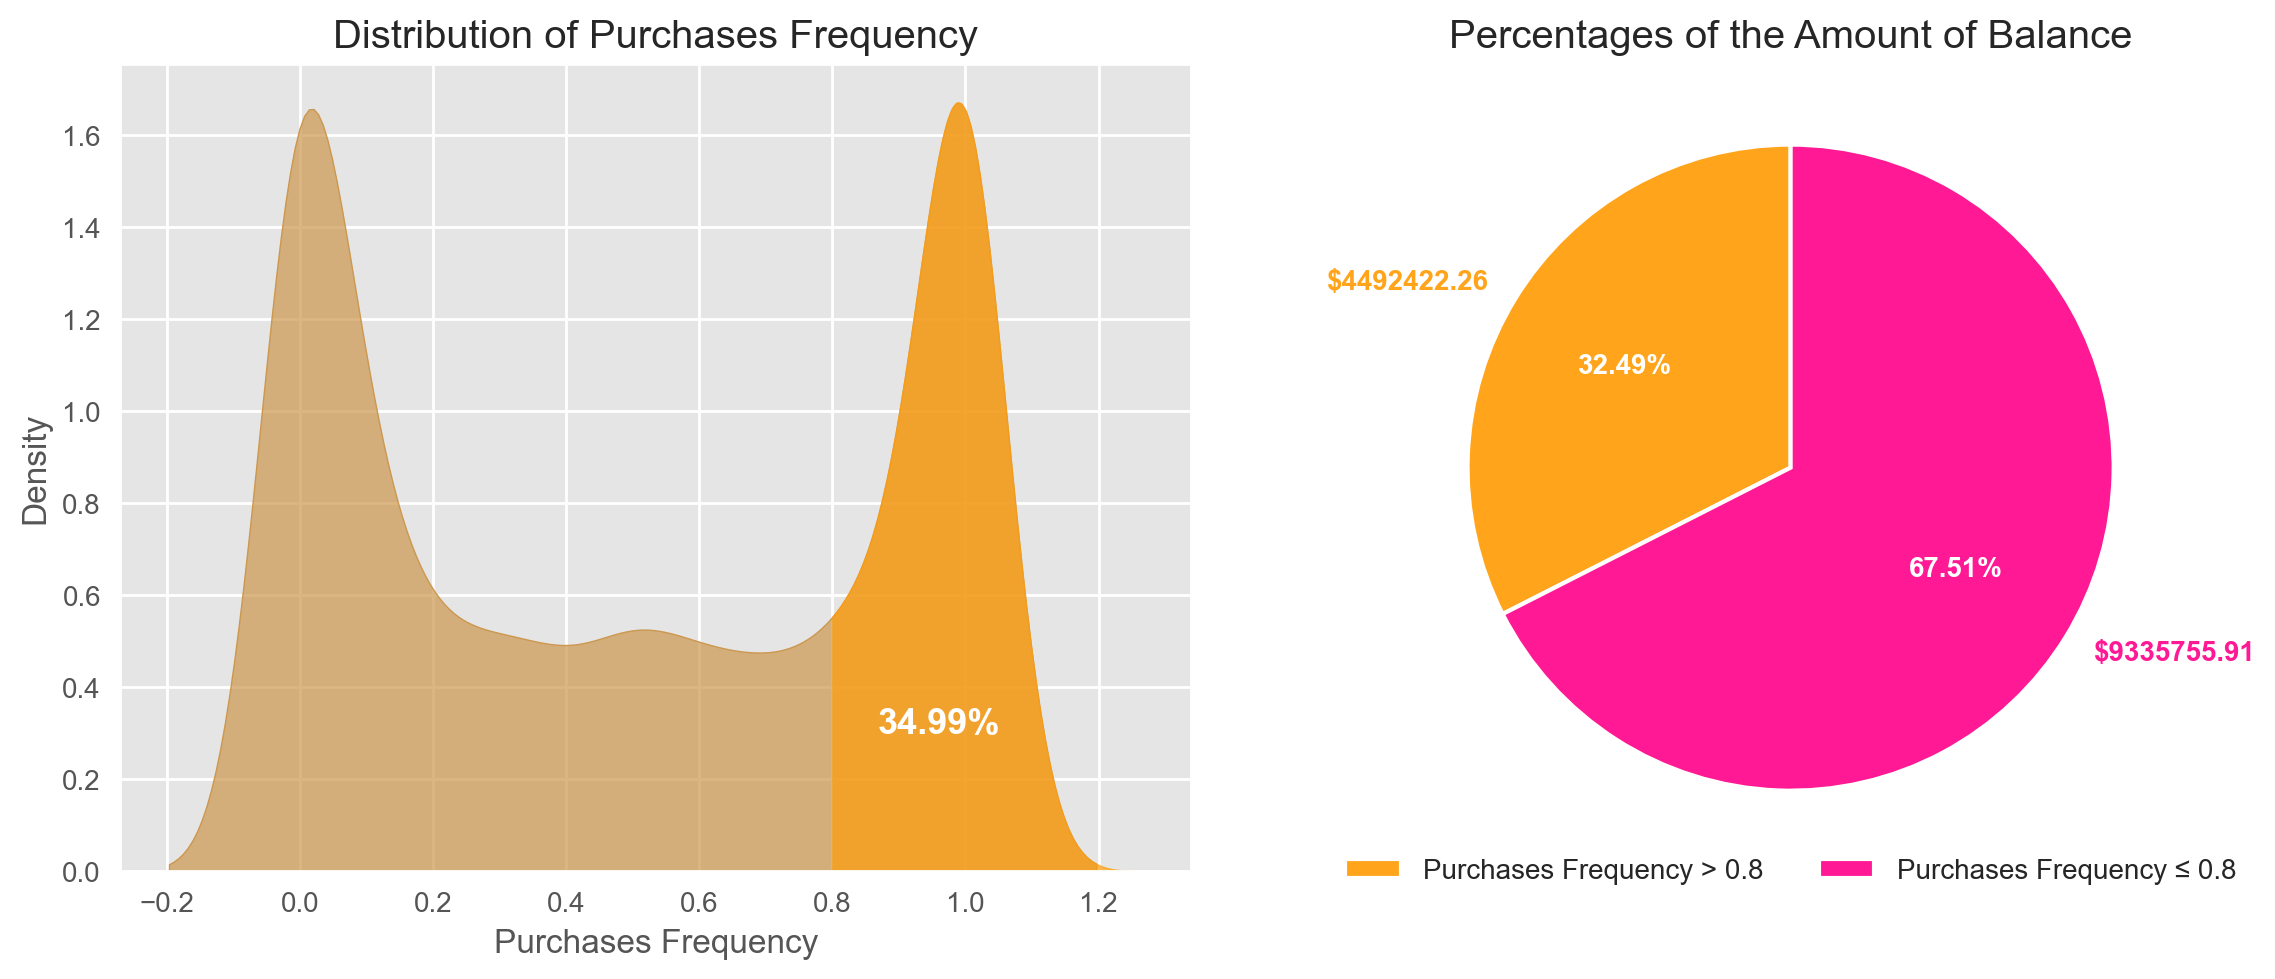

In [20]:
fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=200)

kde_plot = sns.kdeplot(ax=ax[0],data=df,x="purchases_frequency",color= '#CC974E',fill=True,alpha=0.7)
xmin,xmax = kde_plot.get_xlim()
kde = gaussian_kde(df["purchases_frequency"])
x = np.linspace(xmin,xmax,10_000)
kde_y = kde(x)
x0,y0 = [],[]
for i,j in zip(x,kde_y):
    if i > 0.8:
        x0.append(i)
        y0.append(j)
x0,y0 = np.array(x0),np.array(y0)
area0 = round(simps(y0,x0,dx=1) * 100,0)
kde_plot.fill_between(x=x0,y1=y0,color="#FF9E0D",alpha=0.7)
ax[0].text(
    x=0.96,
    y=0.3,
    horizontalalignment="center",
    s=f"{round(len(df[df['purchases_frequency'] > 0.8]) / len(df) * 100,2)}%",
    color="white",
    fontweight="bold",
    fontsize=13
)
ax[0].set_title("Distribution of Purchases Frequency")
ax[0].set_xlabel("Purchases Frequency")

patches,texts,pcts = ax[1].pie(
    [df[df["purchases_frequency"] > 0.8]["balance"].sum(),df[df["purchases_frequency"] <= 0.8]["balance"].sum()],
    labels=[f'${round(df[df["purchases_frequency"] > 0.8]["balance"].sum(),2)}',f'${round(df[df["purchases_frequency"] <= 0.8]["balance"].sum(),2)}'],
    startangle=90,
    colors=["#FFA41B","#FF1994"],
    autopct="%.2f%%",
    wedgeprops={"linewidth":1.5,"edgecolor":"white"}
)
ax[1].set_title("Percentages of the Amount of Balance")
ax[1].legend(patches,["Purchases Frequency > 0.8","Purchases Frequency ≤ 0.8"],ncol=2,bbox_to_anchor=(0.5,0),loc="center")
for index,patch in enumerate(patches):
    texts[index].set_color(patch.get_facecolor())
plt.setp(pcts,color="white",fontweight="bold")
plt.setp(texts,fontweight="bold")

plt.tight_layout()
plt.show()

Regardless of how often customers make purchases, it is noteworthy that less than 10% of individuals in each group have managed to fully pay off their payments.

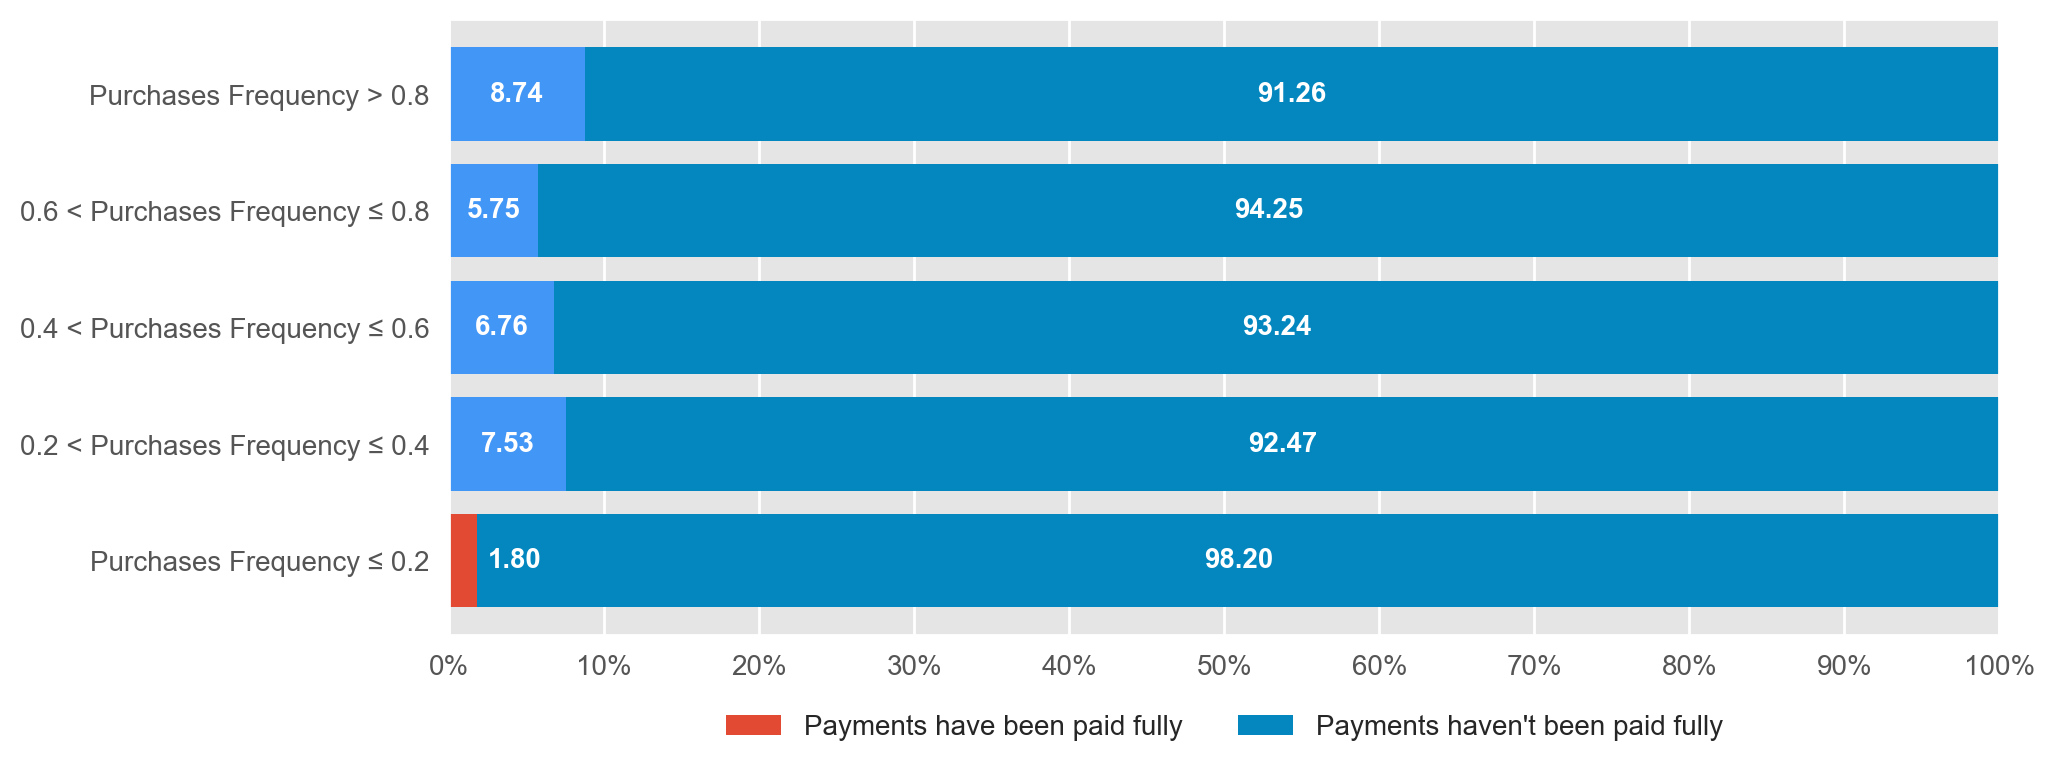

In [14]:
first = df[df["purchases_frequency"] <= 0.2]
second = df[(df["purchases_frequency"] > 0.2) & (df["purchases_frequency"] <= 0.4)]
third = df[(df["purchases_frequency"] > 0.4) & (df["purchases_frequency"] <= 0.6)]
fourth = df[(df["purchases_frequency"] > 0.6) & (df["purchases_frequency"] <= 0.8)]
fifth = df[df["purchases_frequency"] > 0.8]
labels = [
    "Purchases Frequency ≤ 0.2","0.2 < Purchases Frequency ≤ 0.4","0.4 < Purchases Frequency ≤ 0.6",
    "0.6 < Purchases Frequency ≤ 0.8","Purchases Frequency > 0.8"
]

prc_full_payment_is_1,prc_full_payment_not_1 = [],[]
for subset in [first,second,third,fourth,fifth]:
    prc_full_payment_is_1.append(len(subset[subset["prc_full_payment"] == 1]) / len(subset) * 100)
    prc_full_payment_not_1.append(len(subset[subset["prc_full_payment"] != 1]) / len(subset) * 100)

fig,ax = plt.subplots(figsize=(10,4),dpi=200)
n = 0

for label,prc_is_1,prc_not_1 in zip(labels,prc_full_payment_is_1,prc_full_payment_not_1):
    if n == 0:
        ax.barh(label,prc_is_1,label="Payments have been paid fully")
        ax.barh(label,prc_not_1,left=prc_is_1,color="#0487BF",label="Payments haven't been paid fully")
        n += 1
    else:
        ax.barh(label,prc_is_1,color="#4296F5")
        ax.barh(label,prc_not_1,left=prc_is_1,color="#0487BF")
for container in ax.containers[:1]:
    ax.bar_label(container,fmt="%.2f",padding=4,color="white",fontweight="bold")
for container in ax.containers[1:]:
    ax.bar_label(container,fmt="%.2f",label_type="center",color="white",fontweight="bold")

ax.set_xlim(xmax=100)
ax.set_xticks(np.arange(0,101,10),[f"{xtick}%" for xtick in np.arange(0,101,10)])
ax.legend(ncol=2,bbox_to_anchor=(0.5,-0.15),loc="center")

plt.show()

/var/folders/z1/l300r2zd1p9732lzj47l33mr0000gn/T/ipykernel_33805/149290468.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax, fit=norm)
/var/folders/z1/l300r2zd1p9732lzj47l33mr0000gn/T/ipykernel_33805/149290468.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax, 

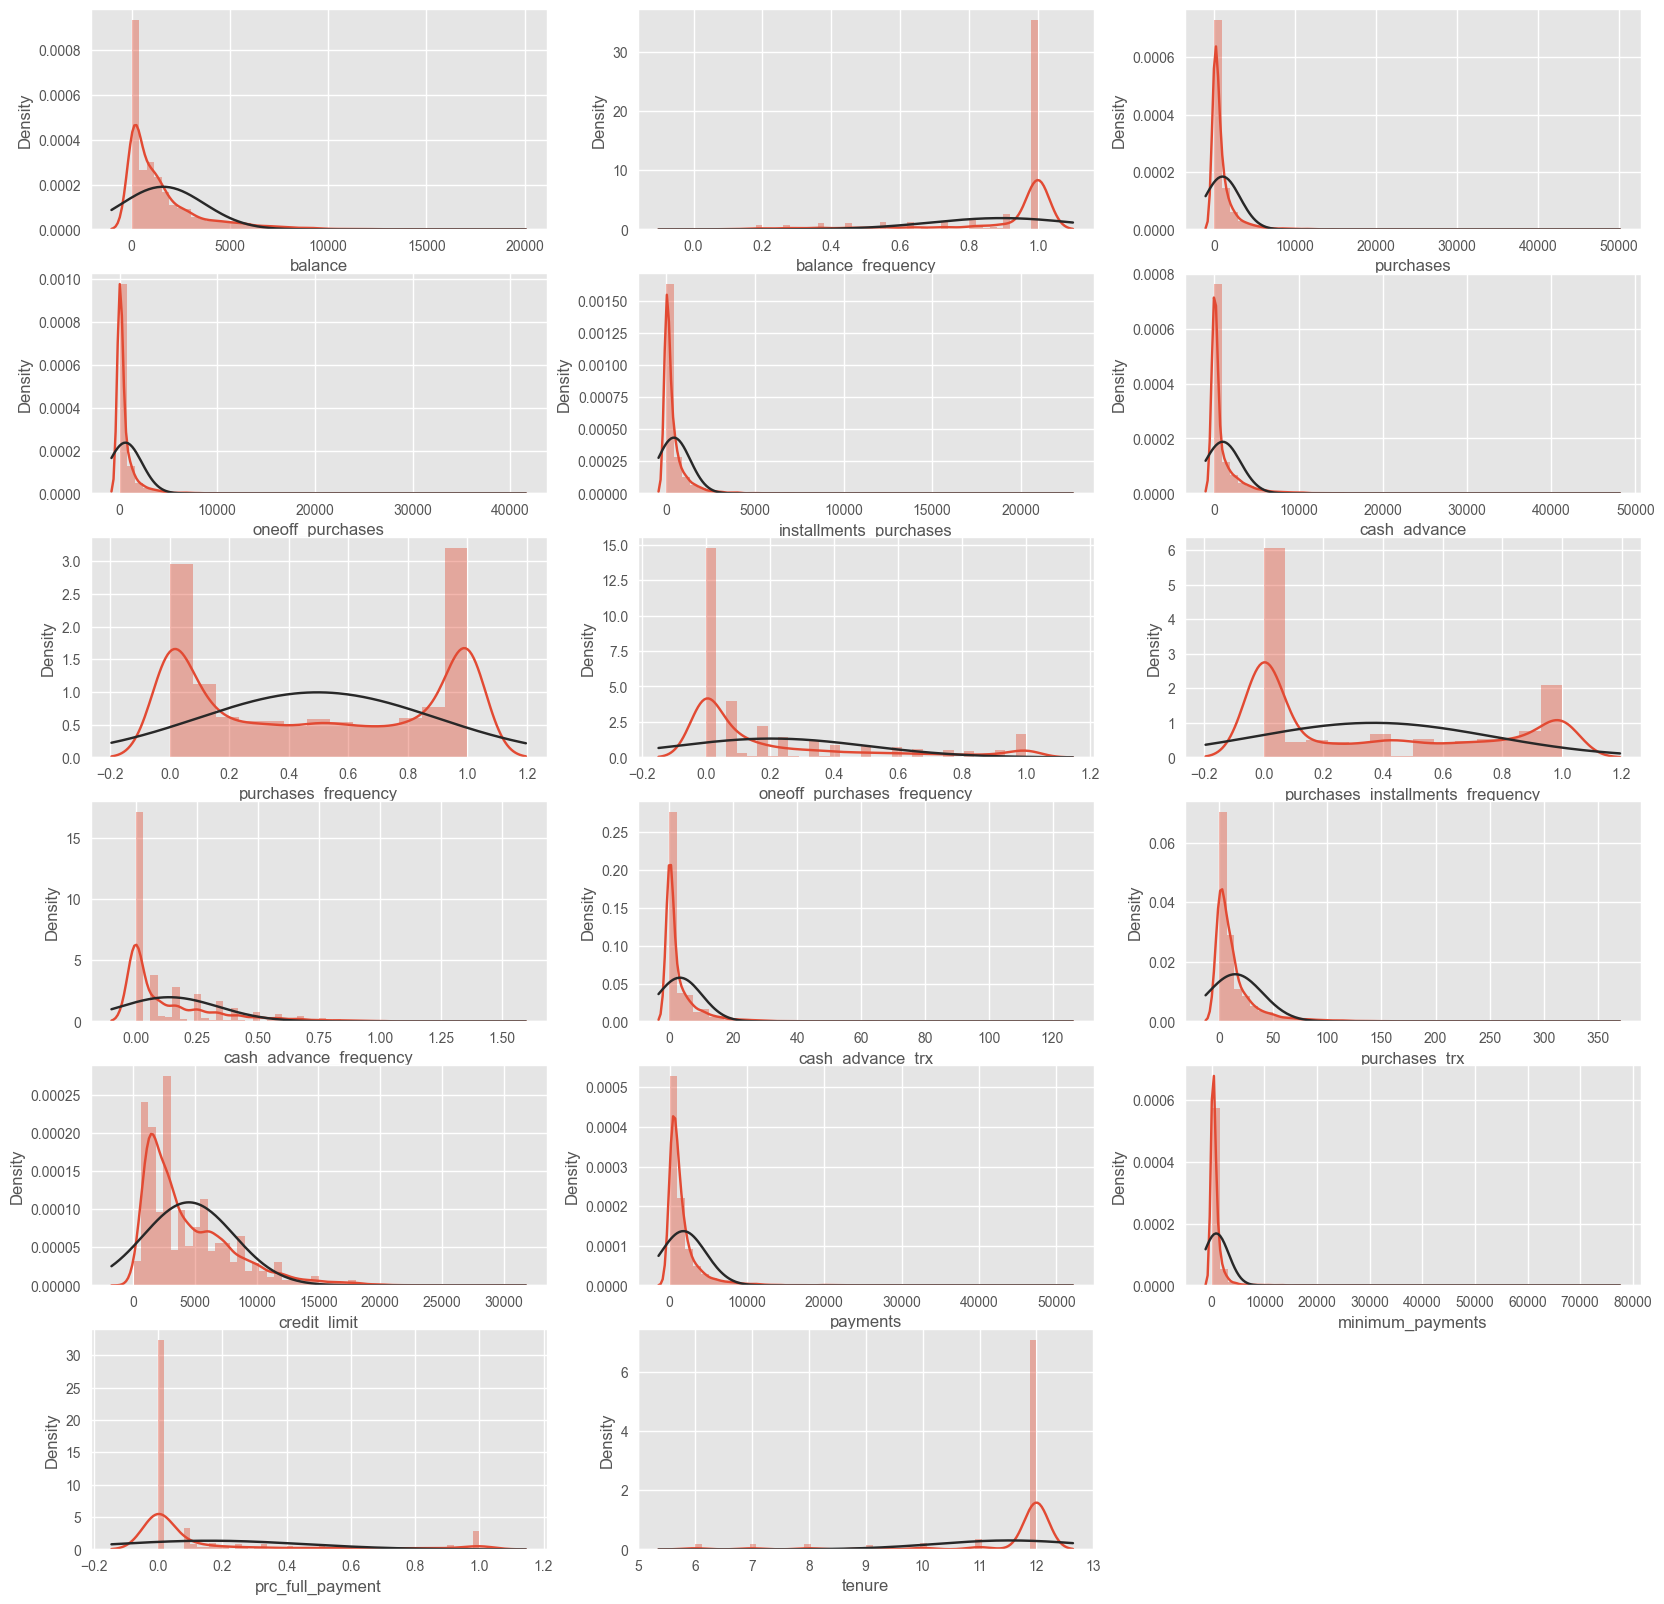

In [13]:
from scipy.stats import norm

plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns):
    ax = plt.subplot(6, 3, i+1)
    sns.distplot(df[col], ax=ax, fit=norm)
    plt.xlabel(col)
plt.show()

# Data Preprocessing

Standardizing data involves transforming it to have a mean of 0 and a standard deviation of 1. This is achieved by subtracting the mean from each data point and dividing by the standard deviation. Standardizing the data is important as it helps ensure that the results of the analysis are not influenced by the varying scales of the variables. Techniques such as factor analysis and k-means clustering are sensitive to the scale of the variables, making data standardization crucial for accurate interpretation and comparison.

In [22]:
df_z = df.copy().apply(zscore,ddof=1)
df_z.head(10)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-0.744582,-0.370025,-0.429159,-0.359139,-0.354805,-0.468628,-0.820721,-0.686240,-0.717137,-0.681913,-0.479409,-0.517593,-0.962520,-0.543910,-0.305490,-0.537696,0.35516
1,0.764108,0.067675,-0.473181,-0.359139,-0.458812,2.568408,-1.236067,-0.686240,-0.926468,0.556990,0.099252,-0.597020,0.677165,0.796806,0.087684,0.212368,0.35516
2,0.426578,0.505375,-0.116406,0.099904,-0.458812,-0.468628,1.256004,2.646498,-0.926468,-0.681913,-0.479409,-0.120460,0.813805,-0.399480,-0.099900,-0.537696,0.35516
3,-0.373889,0.505375,-0.465798,-0.349640,-0.458812,-0.468628,-1.028396,-0.408513,-0.926468,-0.681913,-0.479409,-0.557306,-0.907864,-0.380143,-0.261115,-0.537696,0.35516
4,0.099545,0.505375,0.142054,-0.359139,0.994757,-0.468628,0.425314,-0.686240,0.538851,-0.681913,-0.479409,-0.279313,-0.743895,-0.132112,0.650326,-0.537696,0.35516
5,-0.464773,0.505375,2.798927,3.442203,0.291674,-0.468628,1.256004,2.646498,1.585508,-0.681913,-0.479409,1.944633,2.453490,1.570493,-0.280809,2.837593,0.35516
6,0.106142,0.505375,-0.271899,-0.359139,0.016742,-0.468628,1.256004,-0.686240,1.585508,-0.681913,-0.479409,-0.120460,-0.607255,-0.379892,-0.140047,-0.537696,0.35516
7,-0.279780,0.505375,-0.075651,0.033598,-0.240768,-0.468628,-0.405378,-0.408513,-0.298474,-0.681913,-0.479409,-0.398453,0.677165,-0.376725,-0.232803,-0.537696,0.35516
8,-0.691458,-1.683126,0.118206,0.401767,-0.458812,-0.468628,-0.820721,-0.130782,-0.926468,-0.681913,-0.479409,-0.477880,1.770288,-0.212972,-0.322015,-0.537696,0.35516
9,-0.147024,0.505375,-0.048597,-0.359139,0.544322,-0.468628,1.256004,-0.686240,1.585508,-0.681913,-0.479409,-0.120460,-0.907864,-0.240970,0.551467,-0.537696,0.35516


The Mahalanobis distance serves as a metric for quantifying the separation between a specific point and a given distribution. It is commonly utilized in assessing the multivariate normality, which refers to the statistical characteristic of a dataset conforming to a multivariate normal distribution. To examine multivariate normality using the Mahalanobis distance, we calculate the distance for each data point in our dataset and compare it against a predetermined critical value or threshold. If the calculated distance for a particular point falls below the critical value, it indicates that the point is likely drawn from the same distribution as the remaining data.

In [29]:
# Checking Distance
miu = df_z.mean().values.reshape(-1,1)
s = df_z.cov()
s_invers = np.linalg.inv(s)

mahalanobis = [
    np.linalg.multi_dot(
        [(df_z.iloc[i].values.reshape(-1,1) - miu).T,
        s_invers,
        (df_z.iloc[i].values.reshape(-1,1) - miu)])[0,0] for i in range(len(df_z)
    )
]

multivar_normal = pd.DataFrame({"Mahalanobis":mahalanobis})
multivar_normal["Chi-Square"] = [chi2.ppf(0.5,df=len(df_z.columns)) for i in range(len(multivar_normal))]
multivar_normal["Conclusion"] = ["Inside the Contour" if i < j else "Outside the Contour" for i,j in zip(multivar_normal["Mahalanobis"],multivar_normal["Chi-Square"])]

def highlight_rows(row):
    value = row.loc["Conclusion"]
    if value == "Inside the Contour":
        color = "#C1CCFk"
    elif value == "Outside the Contour":
        color = "#F1CEF4"
    return ["background-color: {}".format(color) for r in row]

multivar_normal.head(10).style.apply(highlight_rows,axis=1)

,Mahalanobis,Chi-Square,Conclusion
0,2.877932,16.338182,Inside the Contour
1,13.433229,16.338182,Inside the Contour
2,21.013228,16.338182,Outside the Contour
3,4.167092,16.338182,Inside the Contour
4,5.475169,16.338182,Inside the Contour
5,39.414161,16.338182,Outside the Contour
6,6.375148,16.338182,Inside the Contour
7,4.306394,16.338182,Inside the Contour
8,13.149008,16.338182,Inside the Contour
9,6.446431,16.338182,Inside the Contour


Based on the provided output, the *Conclusion* column indicates whether each data point falls "Inside the Contour" or "Outside the Contour." Here's the breakdown of the conclusion for each data point:

- Data points 0, 1, 3, 4, 6, 7, 8, and 9 have "Inside the Contour" as their conclusion. This means that their Mahalanobis distance is less than the critical value obtained from the chi-square distribution, indicating that these points are likely drawn from the same distribution as the rest of the data.

- Data points 2 and 5 have "Outside the Contour" as their conclusion. This suggests that their Mahalanobis distance exceeds the critical value, indicating that these points are less likely to be drawn from the same distribution as the rest of the data.

In summary, ***the conclusion*** based on the provided output is that most of the data points (8 out of 10) are considered to be "Inside the Contour," while the remaining two data points are labeled as "Outside the Contour", and since there are more than 50% of our dataset that are inside the contour, it can be said that our dataset is normally distributed. 

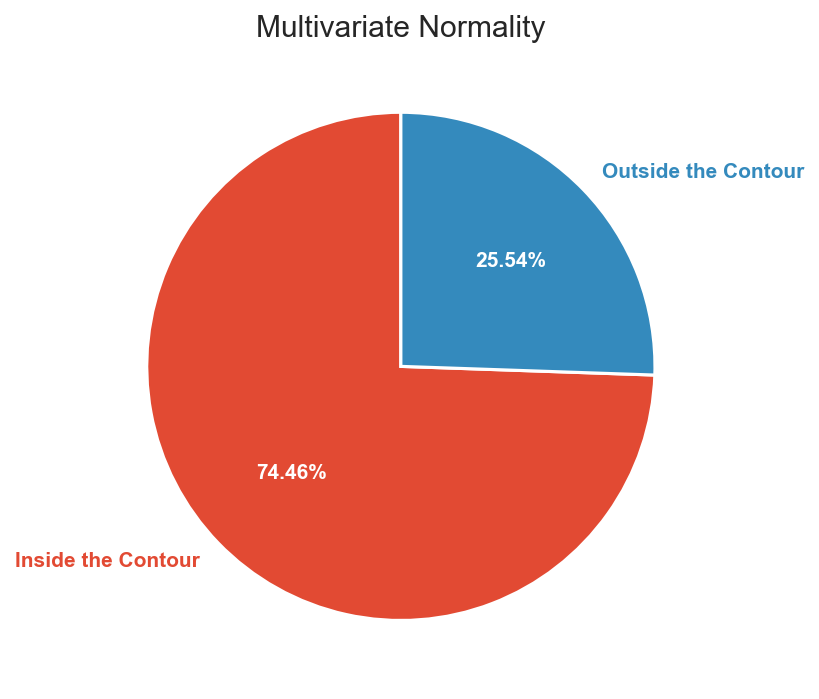

In [32]:
fig,ax = plt.subplots(dpi=150)

patches,texts,pcts = ax.pie(
    multivar_normal.Conclusion.value_counts().values,
    labels=multivar_normal.Conclusion.value_counts().index,
    startangle=90,
    # colors=["#FF9BAA","#FC89AC"],
    autopct="%.2f%%",
    wedgeprops={"linewidth":1.5,"edgecolor":"white"}
)
for index,patch in enumerate(patches):
    texts[index].set_color(patch.get_facecolor())

plt.setp(pcts,color="white",fontweight="bold")
plt.setp(texts,fontweight="bold")
ax.set_title("Multivariate Normality")

plt.show()

Conclusion : In factor analysis, the Kaiser-Meyer-Olkin (KMO) measure and Bartlett's test are commonly employed to evaluate the appropriateness of a dataset for factor analysis. The KMO measure examines the extent of shared variance among variables in the dataset, providing a value between 0 and 1. On the other hand, Bartlett's test evaluates the null hypothesis of no correlation among variables. In our case, as the KMO measure exceeds the threshold of 0.6 and the p-value for Bartlett's test is significant (p < 0.05), indicating a rejection of the null hypothesis, our dataset demonstrates suitability for factor analysis.

In [33]:
print(f"KMO\t\t: {calculate_kmo(df_z)[-1]}")
print(f"Bartlett\t: {calculate_bartlett_sphericity(df_z)[-1]}")

KMO		: 0.6408932395421404
Bartlett	: 0.0


/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


We will utilize a scree plot, a visual depiction of the eigenvalues associated with the variables in a factor analysis, to determine the optimal number of factors to extract from the dataset. Observing the plot, it is evident that there are 5 factors whose eigenvalues surpass the threshold of 1. These factors are considered significant and are deemed to explain a substantial portion, precisely 70.37%, of the variance within the data.

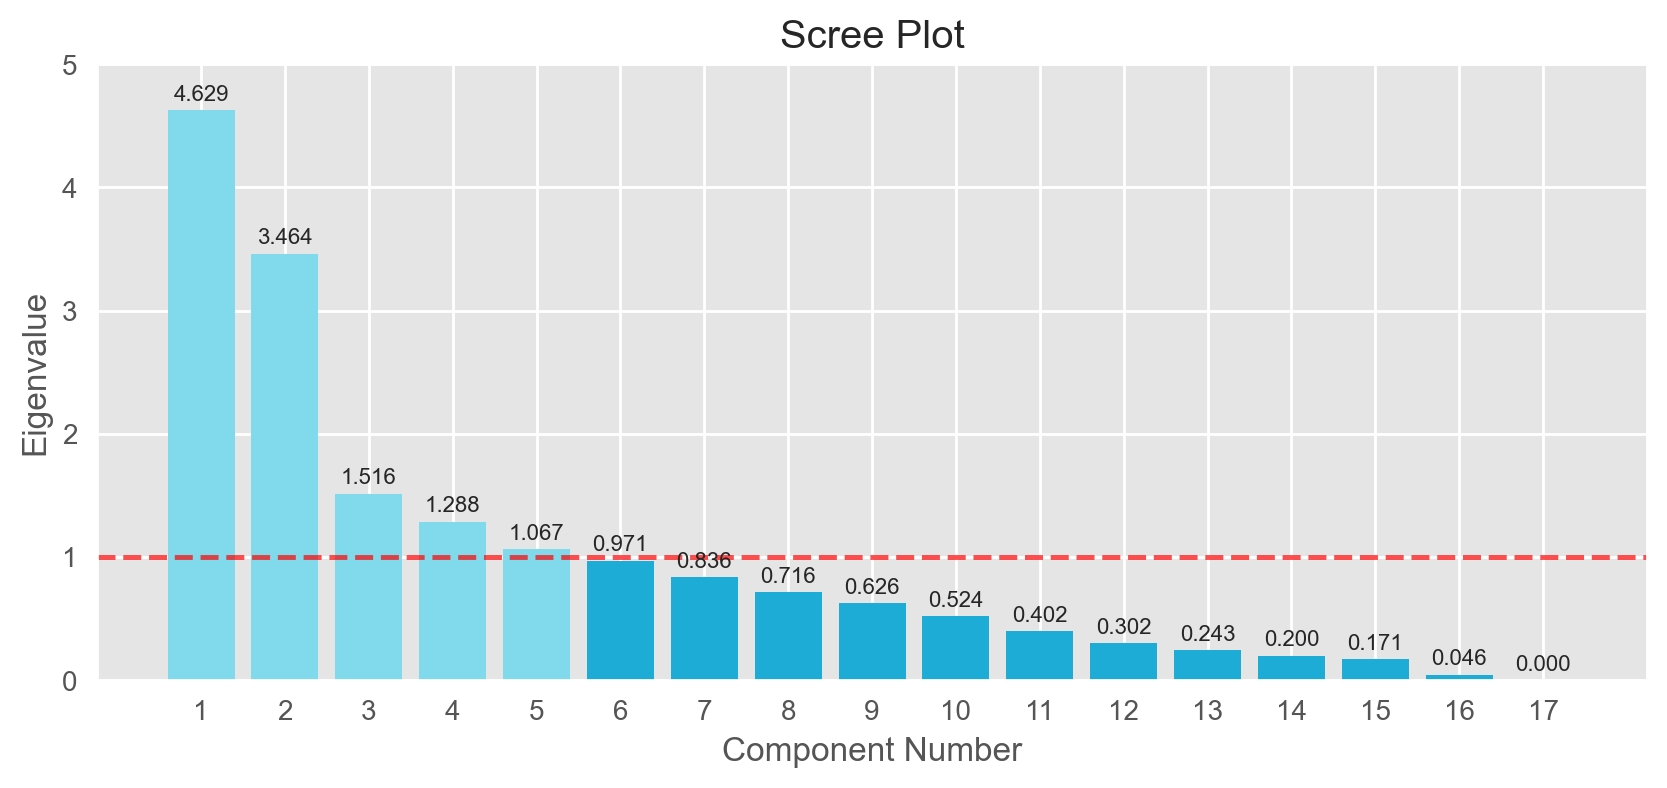

In [34]:
n = len(df_z.columns)
fa = FactorAnalyzer(rotation="varimax",method="principal")
fa.fit(df_z)

fig,ax = plt.subplots(figsize=(10,4),dpi=200)

bars = ax.bar(
    range(1,n + 1),
    fa.get_eigenvalues()[0],
    color=["#80daeb" if eigen > 1 else "#1dacd6" for eigen in fa.get_eigenvalues()[0]]
)

for bars in ax.containers:
    ax.bar_label(bars,fmt="%.3f",fontsize=8,padding=2,fontweight=500)

ax.axhline(y=1,color="red",linestyle="--",alpha=0.7)
ax.set_title("Scree Plot")
ax.set_xticks(range(1,n + 1))
ax.set_xlabel("Component Number")
ax.set_ylabel("Eigenvalue")
ax.set_ylim(ymax=5)
plt.show()

In [39]:
total_variance_explained = pd.DataFrame({
    "Component":range(1,n + 1),
    "Eigenvalue":fa.get_eigenvalues()[0],
    "% of Variance":fa.get_eigenvalues()[0] / len(df_z.columns) * 100
}).set_index("Component")
total_variance_explained["Cumulative"] = total_variance_explained["% of Variance"].cumsum()

total_variance_explained.style.apply(highlight_rows,axis=1)

,Eigenvalue,% of Variance,Cumulative
Component,,,
1,4.629300,27.231177,27.231177
2,3.463632,20.374308,47.605485
3,1.516117,8.918334,56.523818
4,1.287513,7.573609,64.097427
5,1.067025,6.276618,70.374045
6,0.971174,5.712786,76.086831
7,0.835752,4.916188,81.003019
8,0.715825,4.210734,85.213753
9,0.625888,3.681697,88.895450


We utilized a factor analyzer model with 5 factors to examine the dataset. The factor analyzer analysis involved extracting the factor loadings, which represent the relationships between the variables and the factors. These factor loadings indicate the extent to which each variable contributes to each factor. The results from the analysis can provide insights into the underlying latent factors and their influence on the dataset.

In [40]:
fa_5 = FactorAnalyzer(n_factors=5,rotation="varimax",method="principal")
fa_5.fit(df_z)

FactorAnalyzer(method='principal', n_factors=5, rotation='varimax',
               rotation_kwargs={})

To enhance the interpretability of the factors, a rotation technique is applied to the component matrix. Varimax rotation is one of the widely used methods for this purpose. By performing varimax rotation, the rotated component matrix is obtained, which aids in identifying the variables that exhibit stronger associations with each factor. Analyzing the component loadings for each variable in the rotated component matrix provides insights into the overall structure of the data. Variables with high loadings on specific factors are considered to have significant associations with those factors, indicating a stronger relationship between the variable and the underlying factor.

In [41]:
rotated_component_matrix = pd.DataFrame(
    data=fa_5.loadings_,
    columns=[f"Component {component + 1}" for component in range(fa_5.n_factors)],
    index=df_z.columns
)
rotated_component_matrix

,Component 1,Component 2,Component 3,Component 4,Component 5
balance,0.227475,0.523886,-0.060145,0.594524,0.255954
balance_frequency,0.049512,0.157904,0.223390,0.148993,0.762657
purchases,0.884665,-0.060941,0.299793,0.105016,-0.047183
oneoff_purchases,0.912430,-0.069261,0.042115,-0.007289,0.037106
installments_purchases,0.414613,-0.016886,0.631283,0.261577,-0.179850
cash_advance,0.065702,0.856693,-0.097051,0.120192,-0.075990
purchases_frequency,0.220248,-0.188748,0.848001,-0.118278,0.227714
oneoff_purchases_frequency,0.672939,-0.128112,0.159978,-0.216886,0.414639
purchases_installments_frequency,0.025414,-0.118729,0.933708,0.027648,0.056552
cash_advance_frequency,-0.056596,0.865555,-0.181987,-0.021120,0.174385


In [42]:
factors = []
for variable in rotated_component_matrix.index:
    for index,value in enumerate(rotated_component_matrix.loc[variable],start=1):
        if abs(value) == np.max(np.array(abs(rotated_component_matrix.loc[variable]))):
            factors.append(index)

factor_1,factor_2,factor_3,factor_4,factor_5 = ([] for _ in range(fa_5.n_factors))
for variable,factor in zip(rotated_component_matrix.index,factors):
    if factor == 1:
        factor_1.append(variable)
    elif factor == 2:
        factor_2.append(variable)
    elif factor == 3:
        factor_3.append(variable)
    elif factor == 4:
        factor_4.append(variable)
    else:
        factor_5.append(variable)

components = pd.DataFrame(
    data=[factor_1,factor_2,factor_3,factor_4,factor_5],
    index=[f"Component {component + 1}" for component in range(fa_5.n_factors)]
).T
components.replace([None]," ",inplace=True)
components

,Component 1,Component 2,Component 3,Component 4,Component 5
0,purchases,cash_advance,installments_purchases,balance,balance_frequency
1,oneoff_purchases,cash_advance_frequency,purchases_frequency,minimum_payments,prc_full_payment
2,oneoff_purchases_frequency,cash_advance_trx,purchases_installments_frequency,tenure,
3,purchases_trx,,,,
4,credit_limit,,,,
5,payments,,,,


To reduce the dimensionality of our dataset, we can employ factor analysis to extract a subset of 5 dimensions. 

In [43]:
df_fa = pd.DataFrame(data=fa_5.fit_transform(df_z),columns=[f"Component {i + 1}" for i in range(fa_5.n_factors)])
df_fa.head(10)

,Component 1,Component 2,Component 3,Component 4,Component 5
0,-0.468001,-0.806452,-0.800246,0.046945,-0.202331
1,-0.019107,1.169520,-0.788684,0.573086,-0.802249
2,0.809211,-0.786300,-0.606089,-0.284058,1.874243
3,-0.348487,-0.765665,-0.981168,0.129313,0.405370
4,-0.595084,-0.556173,0.640184,1.021097,0.057387
5,3.229177,-0.483759,0.843265,-1.093200,-0.147468
6,-0.883212,-0.469488,1.140295,0.377778,0.549957
7,-0.031964,-0.663676,-0.543344,0.417869,0.326966
8,0.619593,-0.785664,-1.326611,0.335996,-1.044187
9,-0.911578,-0.512975,1.329118,0.711471,0.311871


# Model Definition & Training

The elbow method and the silhouette method are two different approaches that can be used to determine the optimal number of clusters in a k-means clustering analysis. The elbow method is based on the within-cluster sum of squared distances (WCSS), while the silhouette method is based on the silhouette coefficient, which measures the similarity of an observation to its own cluster compared to other clusters. We can use the *yellowbrick* library to create the visualization.

/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

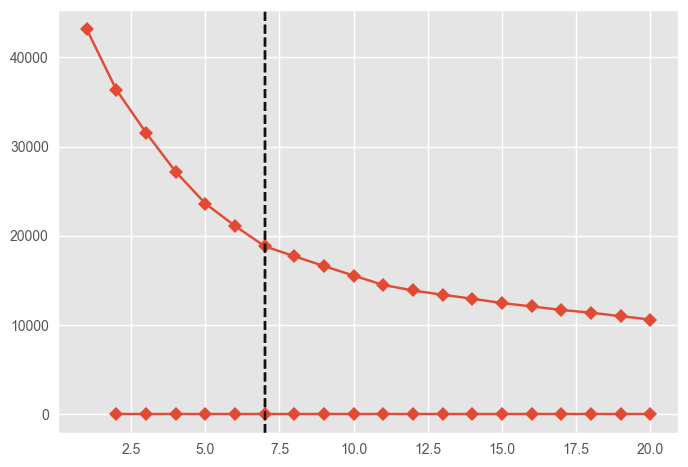

In [44]:
random_state = 42
start = 1
end = 20

scores,elbows_indexes,elbows_scores,methods = [],[],[],["distortion","silhouette"]

for method in methods:
    if method == "silhouette":
        start = 2
    
    kmeans_model = KMeans(init="k-means++",random_state=random_state)
    visualizer = KElbowVisualizer(kmeans_model,k=(start,end + 1),metric=method,timings=False)
    visualizer.fit(df_fa)
    scores.append(visualizer.k_scores_)
    elbows_indexes.append(visualizer.elbow_value_)
    elbows_scores.append(visualizer.elbow_score_)

This step is optional. Since the visualization created by the *yellowbrick* library lacks customization, we can recreate the visualization using the *matplotlib* library to make it better.

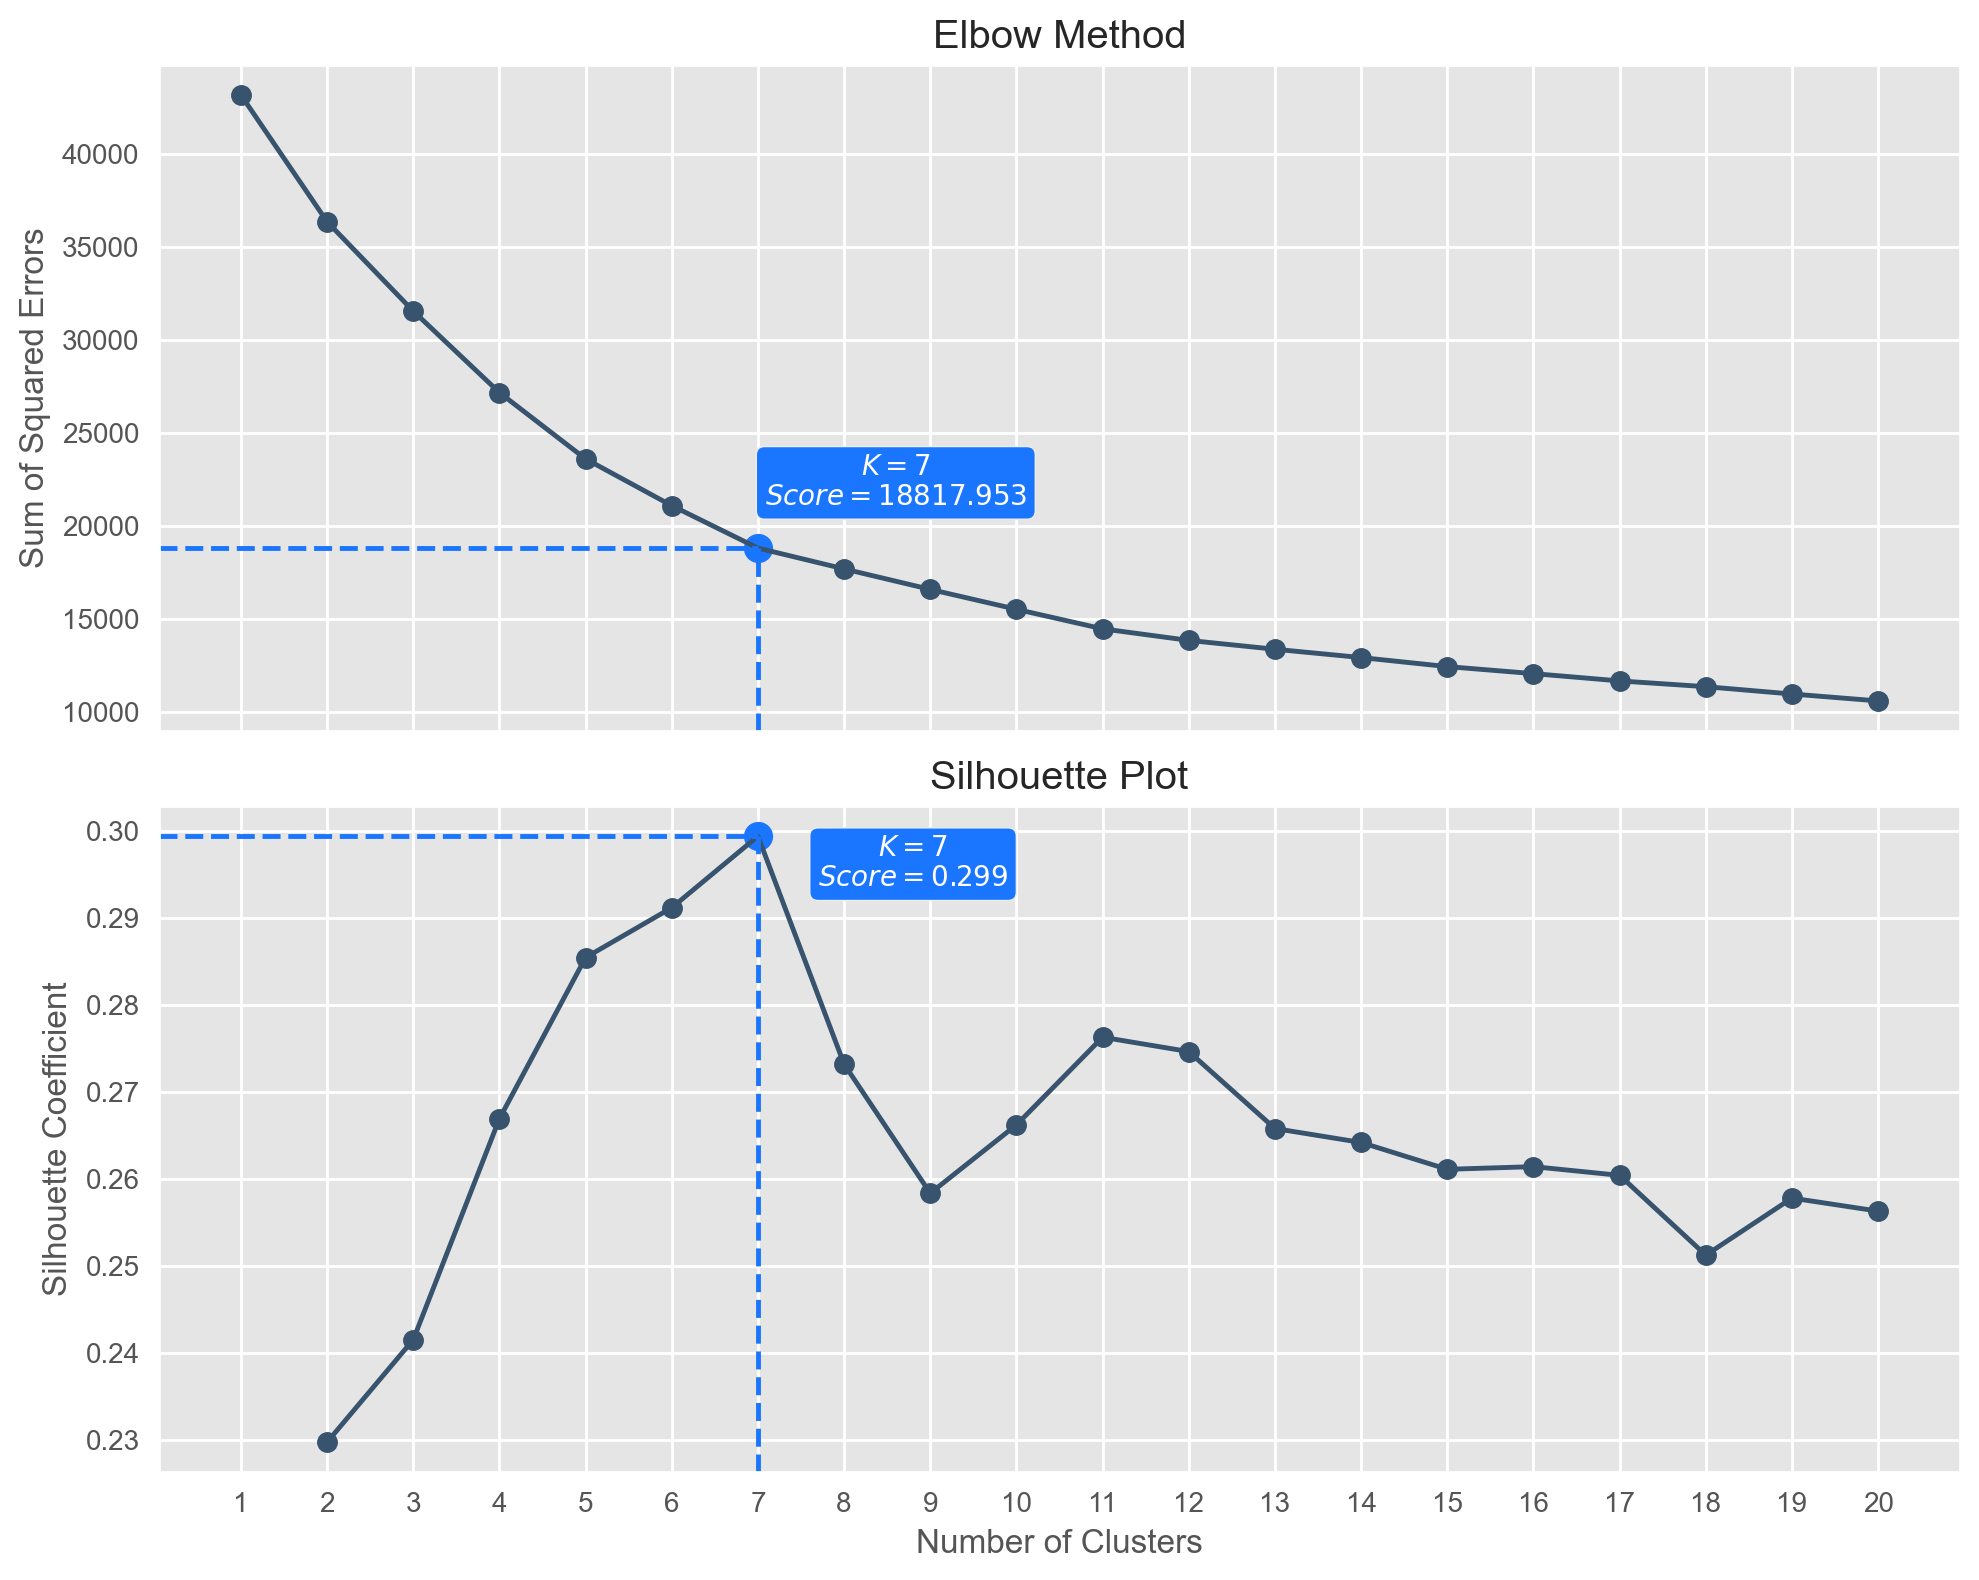

In [45]:
start = 1
end = 20

fig,ax = plt.subplots(2,1,figsize=(10,8),dpi=200,sharex=True)

# Elbow Method
ax[0].plot(range(start,end + 1),scores[0],color="#37536d")
ax[0].scatter(range(start,end + 1),scores[0],color="#37536d")
ax[0].scatter(elbows_indexes[0],elbows_scores[0],color="#1a76ff",s=100)
ax[0].set_xticks(range(start,end + 1))

xmin,xmax = ax[0].get_xlim()
ymin,ymax = ax[0].get_ylim()

ax[0].plot((xmin,elbows_indexes[0]),(elbows_scores[0],elbows_scores[0]),color="#1a76ff",linestyle="--")
ax[0].plot((elbows_indexes[0],elbows_indexes[0]),(ymin,elbows_scores[0]),color="#1a76ff",linestyle="--")
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)
ax[0].set_title("Elbow Method")
ax[0].set_ylabel("Sum of Squared Errors")
ax[0].text(
    x=elbows_indexes[0] + 1.6,
    y=elbows_scores[0] + 2_000,
    horizontalalignment="center",
    verticalalignment="bottom",
    s=f"$ K = {elbows_indexes[0]} $\n$ Score = {round(elbows_scores[0],3)} $",
    color="white",
    fontweight="bold",
    bbox=dict(x=0,facecolor="#1a76ff",boxstyle="round"),
)

# Silhouette Plot
ax[1].plot(range(start + 1,end + 1),scores[1],color="#37536d")
ax[1].scatter(range(start + 1,end + 1),scores[1],color="#37536d")
ax[1].scatter(elbows_indexes[1],elbows_scores[1],color="#1a76ff",s=100)
ax[1].set_xticks(range(start,end + 1))

xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()

ax[1].plot((xmin,elbows_indexes[1]),(elbows_scores[1],elbows_scores[1]),color="#1a76ff",linestyle="--")
ax[1].plot((elbows_indexes[1],elbows_indexes[1]),(ymin,elbows_scores[1]),color="#1a76ff",linestyle="--")
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylim(ymin,ymax)
ax[1].set_title("Silhouette Plot")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Coefficient")
ax[1].text(
    x=elbows_indexes[1] + 1.8,
    y=elbows_scores[1],
    horizontalalignment="center",
    verticalalignment="top",
    s=f"$ K = {elbows_indexes[1]} $\n$ Score = {round(elbows_scores[1],3)} $",
    color="white",
    fontweight="bold",
    bbox=dict(x=0,facecolor="#1a76ff",boxstyle="round")
)

plt.tight_layout()
plt.show()

We can take a look at the more detailed silhouette plot below, where each object is represented by a horizontal line and the silhouette score of the object is represented by the position of the line along the x-axis. The x-axis ranges from -1 to 1 with a score of 1 indicating that the object is very similar to other objects in its own cluster and very dissimilar to objects in other clusters. The silhouette plot also includes a vertical dashed line at the average silhouette score for all the objects in the model. This line serves as a reference point for interpreting the silhouette scores of the individual objects. If the silhouette scores of most of the objects are above the average line, it indicates that the clusters are well-separated and the model has produced good results.

/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

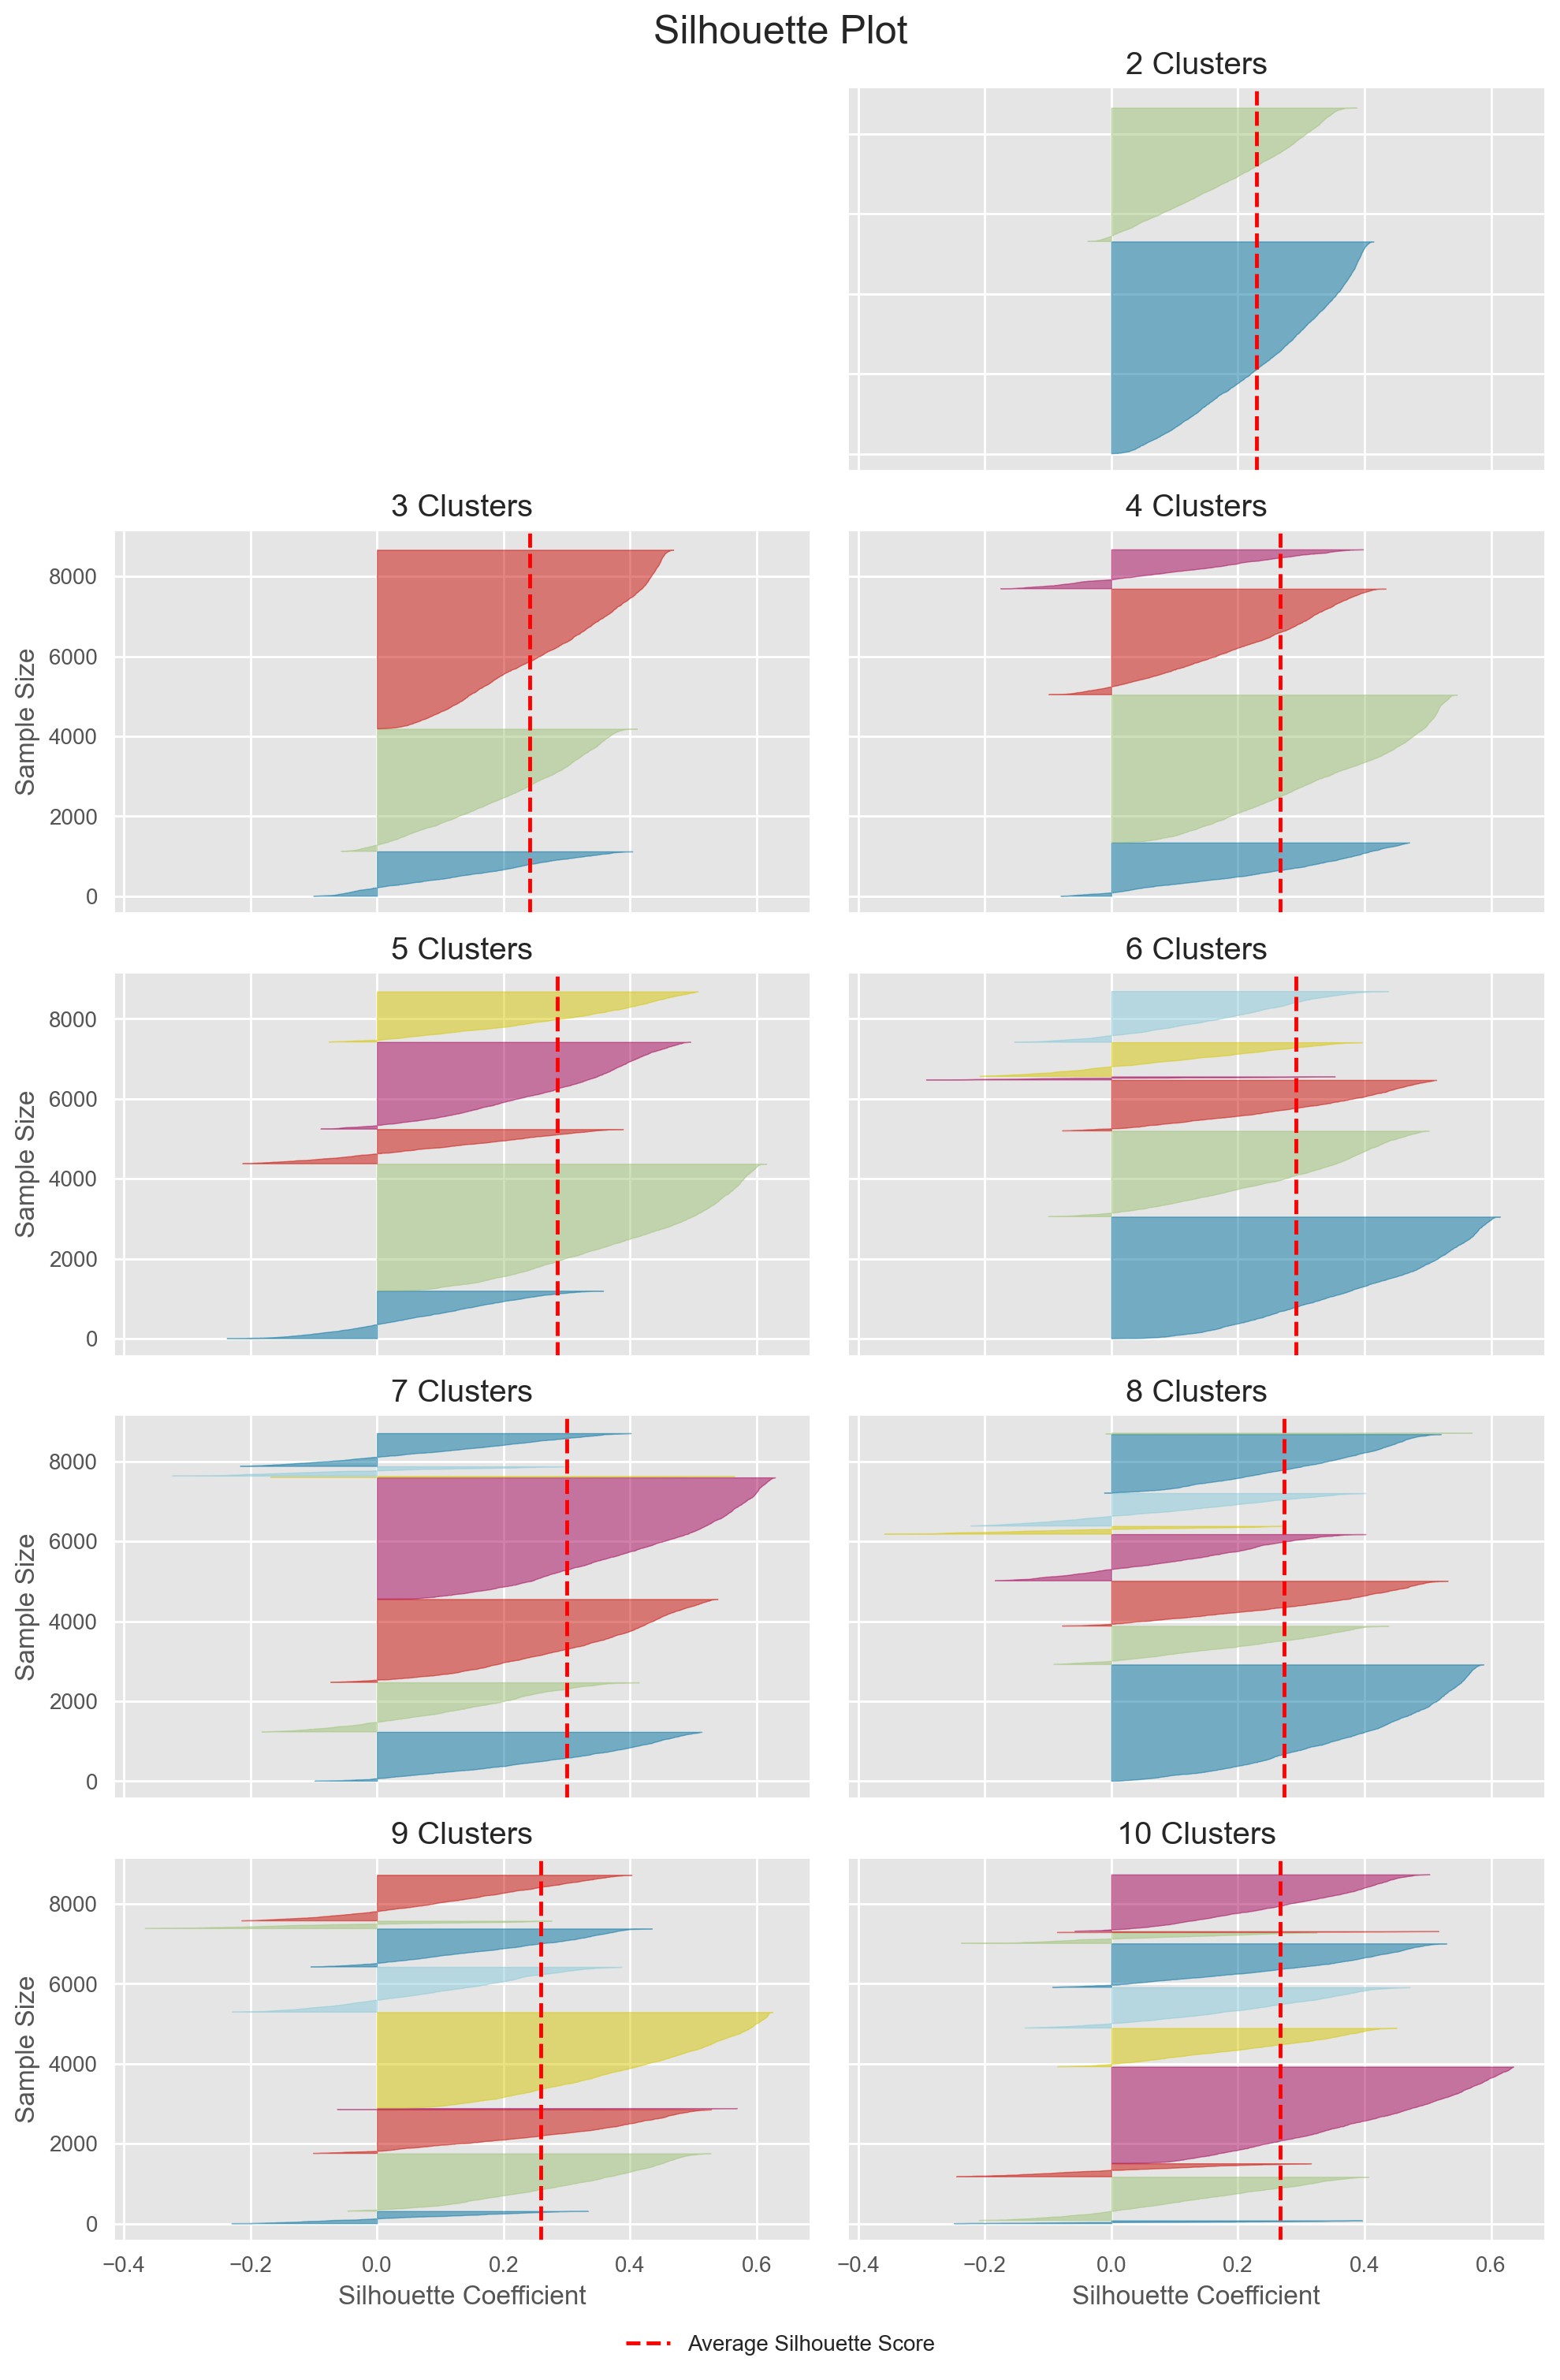

In [46]:
start = 2
end = 10

nrow,ncol = 5,2
fig,ax = plt.subplots(nrow,ncol,figsize=(10,15),dpi=200,sharex=True,sharey=True)

for k in range(start,end + 2):
    q,mod = divmod(k,2)

    if ((q - 1) == 0) & (mod == 0):
        pass
    else:
        k -= 1
        kmeans_model = KMeans(n_clusters=k,init="k-means++",random_state=random_state)
        visualizer = SilhouetteVisualizer(kmeans_model,colors="yellowbrick",ax=ax[q - 1][mod])
        visualizer.fit(df_fa)

        ax[q - 1][mod].set_title(f"{k} Clusters")
        
        if mod == 0:
            ax[q - 1][mod].set_ylabel("Sample Size")
        if (q - 1) == (nrow - 1):
            ax[q - 1][mod].set_xlabel("Silhouette Coefficient")

for axes in ax.flat:
    if not bool(axes.has_data()):
        fig.delaxes(axes)
    
handles,labels = ax[q - 1][mod].get_legend_handles_labels()
fig.legend(handles,labels,loc="center",bbox_to_anchor=(0.5,-0.005))

plt.suptitle("Silhouette Plot",fontsize=18)
plt.tight_layout()
plt.show()

Based on the plots above, we know that the optimal number of clusters is 7. Thus, let's create a k-means model using 7 clusters.

In [47]:
kmeans_model = KMeans(n_clusters=7,init="k-means++",random_state=random_state)
kmeans_model.fit(df_fa)

/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=42)

In the k-means clustering algorithm, the cluster centers are the points that define the center of each cluster. These points are chosen in such a way as to minimize the distance between the data points in the cluster and the cluster center. The k-means algorithm starts by selecting a set of initial cluster centers, which can be randomly chosen or specified by the user. The algorithm then iteratively updates the cluster centers by assigning each data point to the closest cluster center and then recalculating the cluster centers as the mean of the data points in the cluster. This process is repeated until convergence, which is when the cluster centers stop changing or the difference between the within-cluster sum of squares between two consecutive iterations is below a certain threshold.

In [48]:
clusters = []
for iteration in range(1,kmeans_model.n_iter_ + 1):
    temp_model = KMeans(n_clusters=7,init="k-means++",random_state=random_state,max_iter=iteration)
    temp_model.fit(df_fa)
    clusters.append(np.transpose(temp_model.cluster_centers_))

first_index = sum([[f"Iteration {iteration}" for component in range(fa_5.n_factors)] for iteration in range(1,kmeans_model.n_iter_ + 1)],[])
second_index = [f"Component {component + 1}" for component in range(fa_5.n_factors)] * kmeans_model.n_iter_
multi_index = pd.MultiIndex.from_arrays([first_index,second_index])

iteration_history = pd.DataFrame(
    data=np.ravel(clusters).reshape(-1,kmeans_model.n_clusters),
    columns=[f"Cluster {cluster}" for cluster in range(7)],
    index=multi_index
)
iteration_history

/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/agyaldira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

Cluster 0  Cluster 1  Cluster 2  Cluster 3   
Iteration 1  Component 1  -0.265150   0.122292   0.699596  -0.228136  \
             Component 2  -0.171637   2.485550  -0.563555  -0.163389   
             Component 3   0.255228  -0.194595  -0.381062   1.206700   
             Component 4   2.746243   0.015496  -0.325695  -0.054012   
             Component 5  -0.372636  -0.046181   0.920570   0.282551   
...                             ...        ...        ...        ...   
Iteration 37 Component 1  -0.083638   1.250813  -0.501424  -0.233754   
             Component 2  -0.391159  -0.457259  -0.249096  -0.141314   
             Component 3  -0.519023   0.252939   1.196861  -0.753467   
             Component 4  -0.278889  -0.512846  -0.142431   0.212179   
             Component 5  -1.720608   0.919166   0.008818   0.323483   

                          Cluster 4  Cluster 5  Cluster 6  
Iteration 1  Component 1   7.827630  -0.263067  -0.149717  
             Component 2  -0.044460   0.016953  -0.438968  
             Component 3   0.833393  -0.833462  -0.104043  
             Component 4   1.141061   0.151003  -0.371046  
             Component 5  -2.106617   0.155652  -1.541347  
...                             ...        ...        ...  
Iteration 37 Component 1  10.681778   0.325852  -0.021913  
             Component 2   0.060157   0.355349   2.316326  
             Component 3  -0.294003   1.133088  -0.157054  
             Component 4   0.860399   3.368168  -0.217823  
             Component 5  -2.803904  -0.320052   0.142241  

[185 rows x 7 columns]

In [49]:
final_cluster_centers = pd.DataFrame(
    data=kmeans_model.cluster_centers_,
    columns=df_fa.columns,
    index=[f"Cluster {cluster}" for cluster in range(kmeans_model.n_clusters)]
).T
final_cluster_centers

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
Component 1,-0.083638,1.250813,-0.501424,-0.233754,10.681778,0.325852,-0.021913
Component 2,-0.391159,-0.457259,-0.249096,-0.141314,0.060157,0.355349,2.316326
Component 3,-0.519023,0.252939,1.196861,-0.753467,-0.294003,1.133088,-0.157054
Component 4,-0.278889,-0.512846,-0.142431,0.212179,0.860399,3.368168,-0.217823
Component 5,-1.720608,0.919166,0.008818,0.323483,-2.803904,-0.320052,0.142241


Assign data points to clusters and calculate the distance between the data points and the cluster centers.

In [50]:
df_labeled = df_fa.copy()
df_labeled["Cluster"] = kmeans_model.labels_
df_labeled["Distance"] = np.min(kmeans_model.transform(df_fa),axis=1)
df_labeled.head(10)

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster,Distance
0,-0.468001,-0.806452,-0.800246,0.046945,-0.202331,3,0.896243
1,-0.019107,1.169520,-0.788684,0.573086,-0.802249,3,1.778518
2,0.809211,-0.786300,-0.606089,-0.284058,1.874243,1,1.416235
3,-0.348487,-0.765665,-0.981168,0.129313,0.405370,3,0.684396
4,-0.595084,-0.556173,0.640184,1.021097,0.057387,2,1.330081
5,3.229177,-0.483759,0.843265,-1.093200,-0.147468,1,2.395335
6,-0.883212,-0.469488,1.140295,0.377778,0.549957,2,0.872344
7,-0.031964,-0.663676,-0.543344,0.417869,0.326966,3,0.632498
8,0.619593,-0.785664,-1.326611,0.335996,-1.044187,0,1.462189
9,-0.911578,-0.512975,1.329118,0.711471,0.311871,2,1.037468


Visualize the number of data points in each cluster.

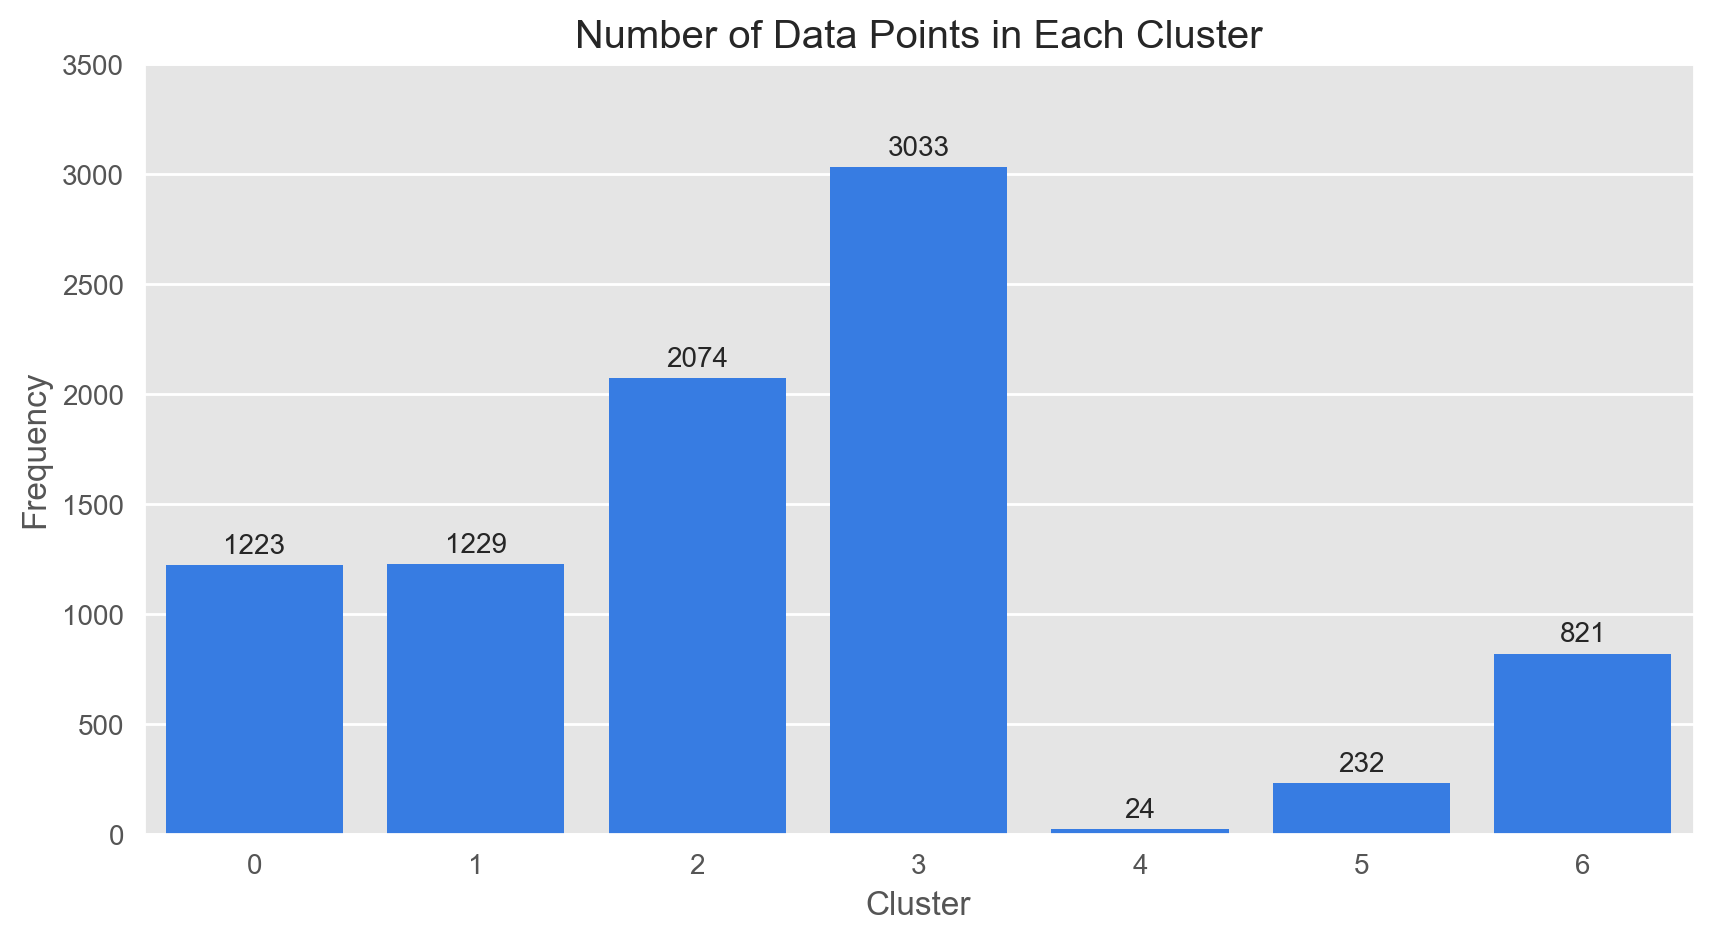

In [51]:
fig,ax = plt.subplots(figsize=(10,5),dpi=200)

sns.countplot(data=df_labeled,x="Cluster",color="#1a76ff")
ax.set_title("Number of Data Points in Each Cluster")
ax.set_ylim(ymax=3500)
ax.set_ylabel("Frequency")

for bars in ax.containers:
    ax.bar_label(bars,fmt="%.0f",padding=2,fontweight=500)

plt.show()

# Model Evaluation

It's important to note that unsupervised machine learning techniques, such as k-means clustering, do not have a "right" or "wrong" answer. Unlike supervised learning techniques, which are trained on labeled data and can be evaluated using metrics such as accuracy, unsupervised learning techniques do not have ground truth labels to compare their predictions to.

In an ANOVA table for k-means clustering, the F-value and p-value are used to determine whether the difference between the means of the clusters is statistically significant. The F-value is the ratio of the mean squares between the groups (i.e., the clusters) to the mean squares within the groups, while the p-value is the probability that the difference between the means of the clusters is due to chance. Since the F-value for the clusters is significantly large and the p-value for the clusters is small (typically less than 0.05), it suggests that there is a statistically significant difference between the means of the clusters. This may indicate that the clusters are distinct and meaningful.

In [52]:
stats,p_values = [],[]
for feature in df_fa.columns:
    groups = [df_fa[feature][kmeans_model.labels_ == label] for label in range(kmeans_model.n_clusters)]
    stat,p_value = f_oneway(*groups)
    stats.append(stat)
    p_values.append(p_value)

anova = pd.DataFrame(
    data=[stats,p_values],
    columns=[f"Component {component + 1}" for component in range(fa_5.n_factors)],
    index=["F","P-Value"]
).T
anova

,F,P-Value
Component 1,2378.660069,0.0
Component 2,2042.480729,0.0
Component 3,2425.100148,0.0
Component 4,883.174984,0.0
Component 5,2182.425628,0.0


Visualize the clustering of data points based on their features using a scatter plot. To reduce the computational cost, we'll only use component 1.

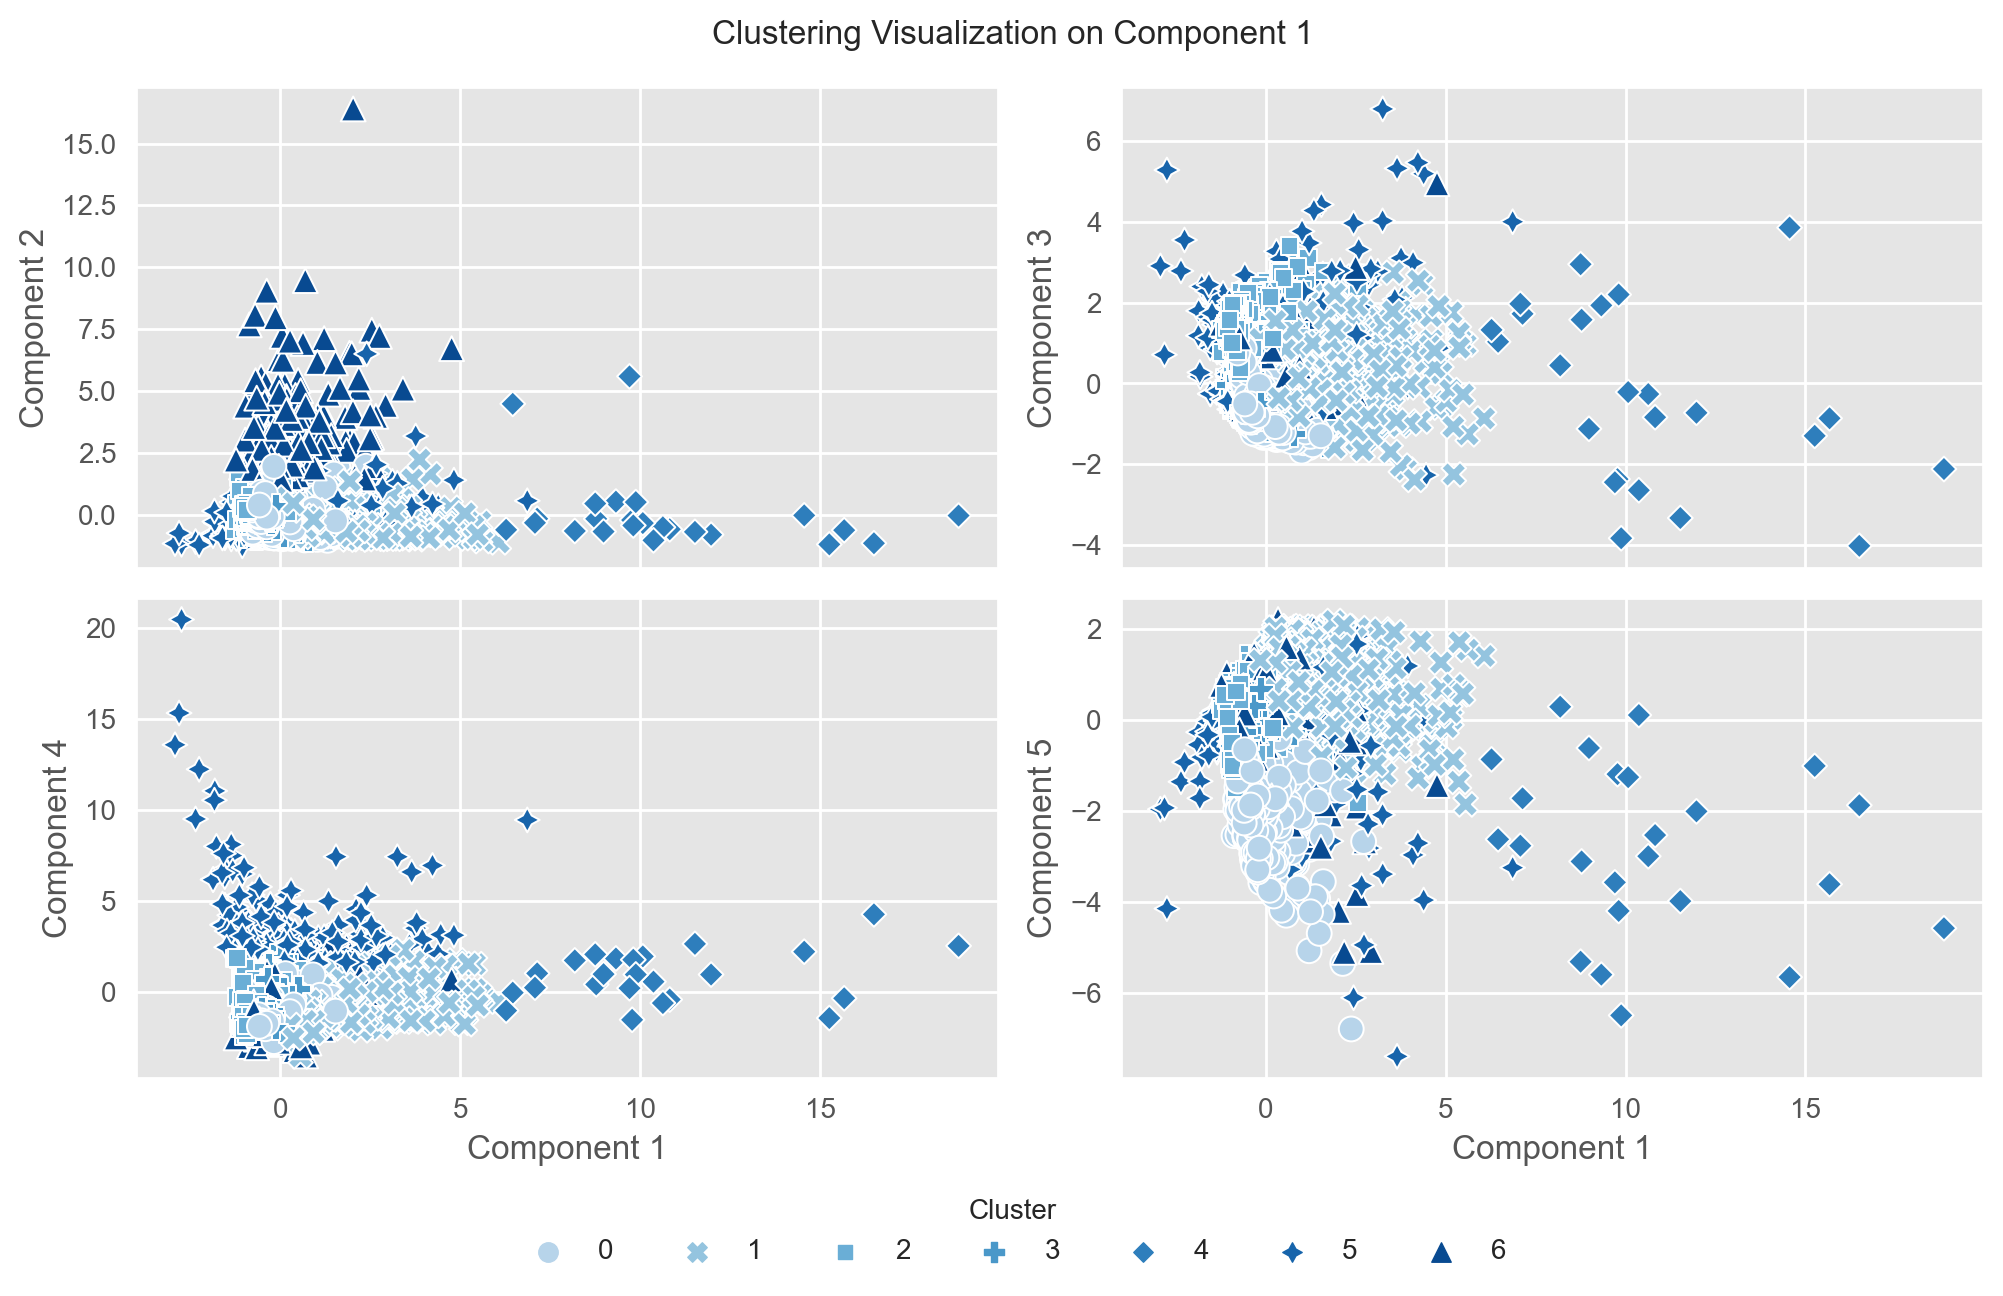

In [53]:
fig,ax = plt.subplots(2,2,figsize=(10,6),dpi=200,sharex=True)

for feature,length in zip(df_fa.columns[1:],range(len(df_fa.columns[1:]))):
    q,mod = divmod(length,2)
    sns.scatterplot(
        data=df_labeled,
        x="Component 1",
        y=feature,
        ax=ax[q][mod],
        hue="Cluster",
        style="Cluster",
        s=80,
        palette=sns.color_palette("Blues",n_colors=9)[2:],
    )
    ax[q][mod].get_legend().remove()

handles,labels = ax[q][mod].get_legend_handles_labels()
fig.legend(handles,labels,bbox_to_anchor=(0.5,-0.03),loc="center",ncol=kmeans_model.n_clusters,title="Cluster")

plt.suptitle("Clustering Visualization on Component 1")
plt.tight_layout()
plt.show()

Save the models for deployment and future use.

In [54]:
models = [fa_5,kmeans_model]
names = ["factor_analyze","kmeans_clustering"]
extension = "pkl"

for model,name in zip(models,names):
    with open(f"{name}.{extension}","wb") as files:
        dump(model,files)
    print(f"{name}.{extension} has been downloaded")

factor_analyze.pkl has been downloaded
kmeans_clustering.pkl has been downloaded


# Conclusion

After performing factor analysis and k-means clustering on a dataset of credit card customers, we were able to identify 7 distinct clusters of credit card users based on their spending patterns and payment habits. These findings suggest that credit card customers can be effectively segmented based on their spending and payment behaviors, and that these clusters may be useful for targeted marketing and risk assessment efforts. Further analysis may be needed to fully understand the characteristics and needs of each cluster, but the results of this study provide a strong foundation for further research in this area.